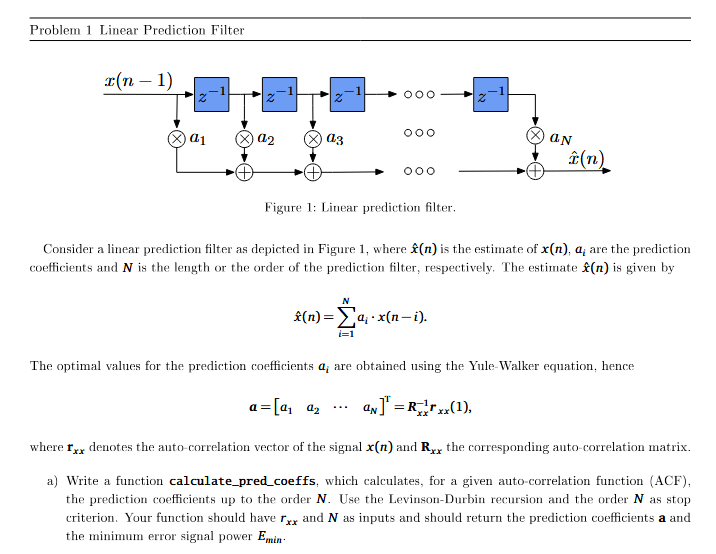

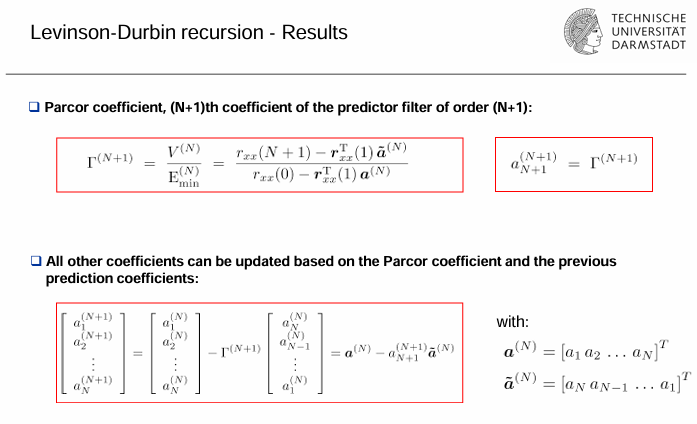

In [96]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
import sounddevice as sd

In [97]:
def calculate_pred_coeffs(rxx, N):
    # rxx should have N+1 elements: [rxx[0], ..., rxx[N]]
    a = np.zeros(N + 1)
    parcor_coeffs = np.zeros(N + 1)
    Emin = np.zeros(N + 1)

    # First coeff value / Initialization
    parcor = rxx[1] / rxx[0]
    a[1] = parcor
    
    for i in range(2, N+1): # the last index that i pass should be N-1 -> last i calculates a[N]
        # i corresponds to the index N + 1

        # Calculating Parcor Coefficient
        rxx_1 = rxx[1:i]
        V_n = rxx[i] - np.dot(rxx_1, a[1:i][::-1]) # a_inverse
        Emin_n = rxx[0] - np.dot(rxx_1, a[1:i])
        parcor = V_n / Emin_n

        # Calculating new a
        a_new = np.zeros(i + 1)
        a_new[1:i] = a[1:i] - parcor * a[1:i][::-1]
        a_new[i] = parcor
        a[:i + 1] = a_new

        # Saving parcor value
        parcor_coeffs[i] = parcor

        # Saving Emin value
        Emin[i-1] = Emin_n

    Emin[N] = rxx[0] - np.dot(rxx[1:N+1], a[1:N+1])

    return a, Emin

calculate_pred_coeffs(np.ones(11)/np.arange(1, 12), 10)

(array([0.        , 0.43117987, 0.07649683, 0.03880376, 0.02496312,
        0.01809627, 0.01415077, 0.01172036, 0.01025636, 0.00972442,
        0.01381754]),
 array([0.        , 0.75      , 0.74074074, 0.73784722, 0.73649412,
        0.73572755, 0.73524105, 0.73490813, 0.73466773, 0.73448698,
        0.73434675]))

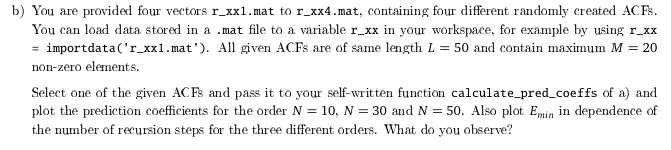

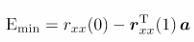

In [98]:
def calculate_Emin(rxx, a, N):
    return rxx[0] - np.dot(rxx[1:N+1], a[1:N+1])

dict_keys(['__header__', '__version__', '__globals__', 'r_xx'])


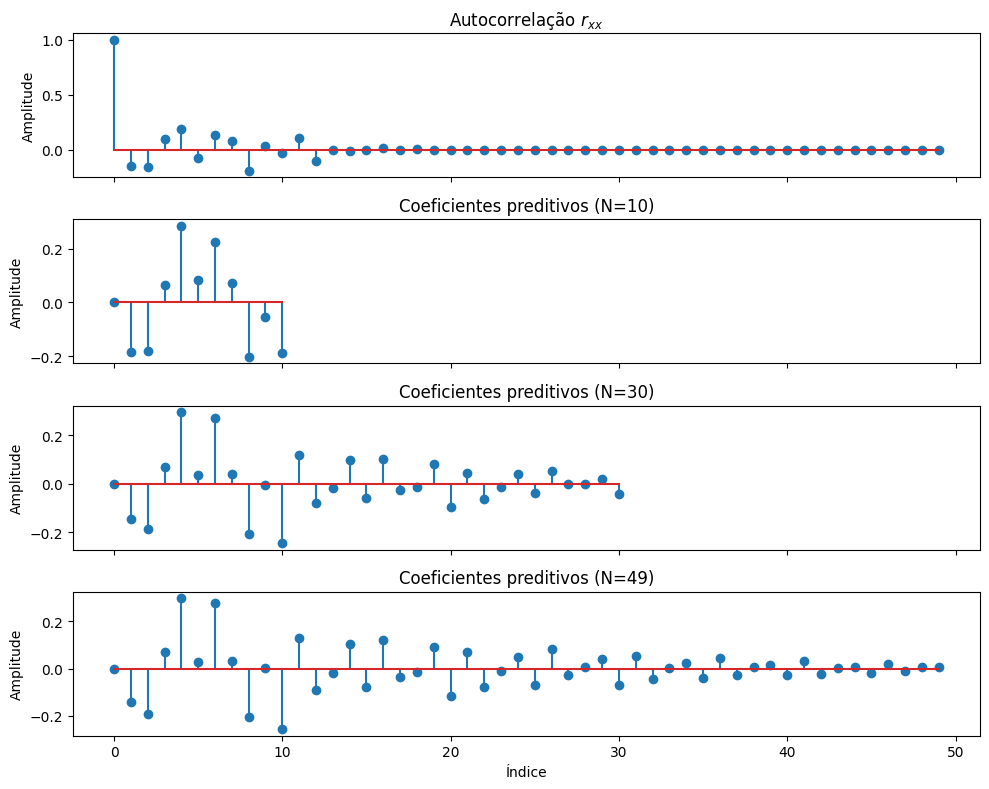

0.0833916134403208
0.03435095452161434
0.02614409273768378


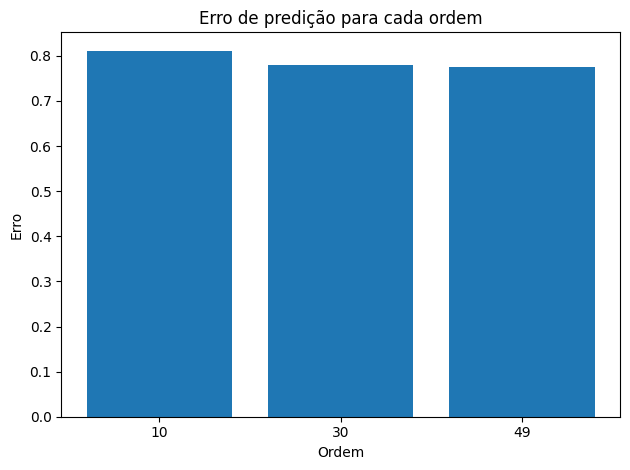

In [99]:
mat_data = loadmat('r_xx3.mat')
print(mat_data.keys())

rxx = mat_data['r_xx'].flatten()
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axs[0].stem(rxx)
axs[0].set_title('Autocorrelação $r_{xx}$')
axs[0].set_ylabel('Amplitude')

a10, Emin_10 = calculate_pred_coeffs(rxx, N=10)
axs[1].stem(a10)
axs[1].set_title('Coeficientes preditivos (N=10)')
axs[1].set_ylabel('Amplitude')

a30, Emin_30 = calculate_pred_coeffs(rxx, N=30)
axs[2].stem(a30)
axs[2].set_title('Coeficientes preditivos (N=30)')
axs[2].set_ylabel('Amplitude')

a49, Emin_49 = calculate_pred_coeffs(rxx, N=49)
axs[3].stem(a49)
axs[3].set_title('Coeficientes preditivos (N=49)')
axs[3].set_xlabel('Índice')
axs[3].set_ylabel('Amplitude')

orders = [10, 30, 49]
a_list = [a10, a30, a49]
errors = [calculate_Emin(rxx, a, N) for a, N in zip(a_list, orders)]
plt.tight_layout()
plt.show()

plt.bar([str(N) for N in orders], errors)
plt.title('Erro de predição para cada ordem')
plt.ylabel('Erro')
plt.xlabel('Ordem')

print(a10[5])
print(a30[5])
print(a49[5])

plt.tight_layout()
plt.show()

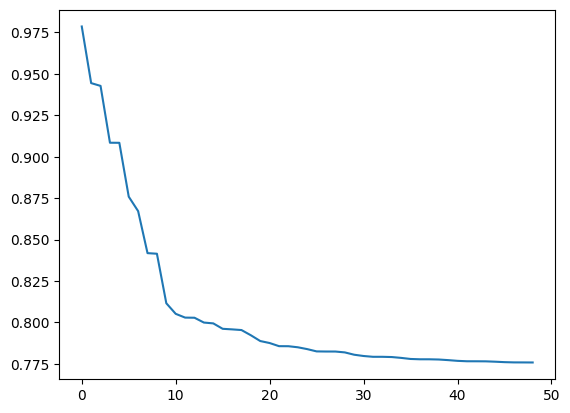

In [100]:
plt.plot(Emin_49[1:])
# plt.ylim([0, 1])

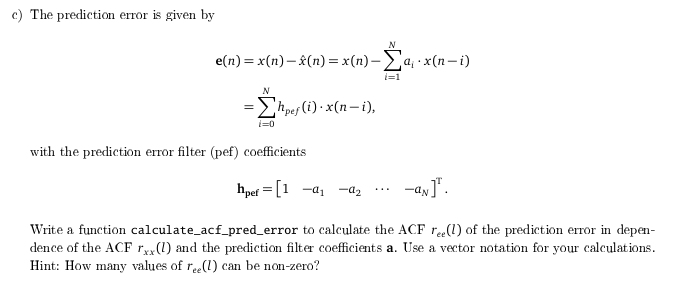

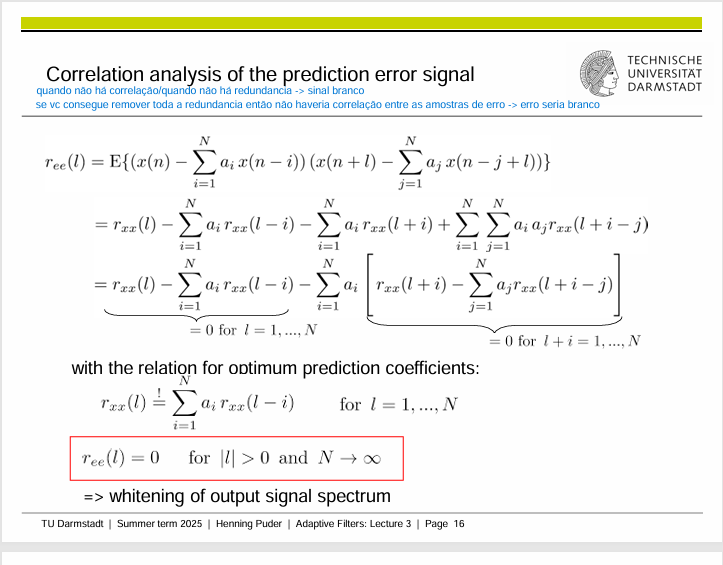

[0.7757989893805534, 6.310390239010835e-05, -2.233992114290306e-05, -0.00014296683895119038, 0.0003864014042388969, -0.0005706977754916868, 0.0005529396202590433, -0.00027385650619169213, -0.000244970507918459, 0.0008085532402460974, -0.0011769166868450013, 0.0011488992393139258, -0.0006415074573093331, -0.0002005167581247949, 0.001138480449094472, -0.0017503967958628546, 0.00174304012650141, -0.001055101494486831, -0.00019105510758526267, 0.0014941743370507506, -0.0024770911919602674, 0.002606498218440072, -0.0016888508115024841, 0.0001625263193212484, 0.0016717736653711307, -0.0029818127188213357, 0.003286969299714737, -0.0023546628232888824, 0.00017952892938214612, 0.002084740819924369, -0.0039311786514630255, 0.004598677633639777, -0.0036063913197695576, 0.0011337351683704156, 0.0020281887735668297, -0.004178405497683192, 0.005157192417689327, -0.004086341965540038, 0.0011771890031182695, 0.0025392002412035412, -0.006430189824243793, 0.006740451719556889, -0.006402712133312917, 0.0

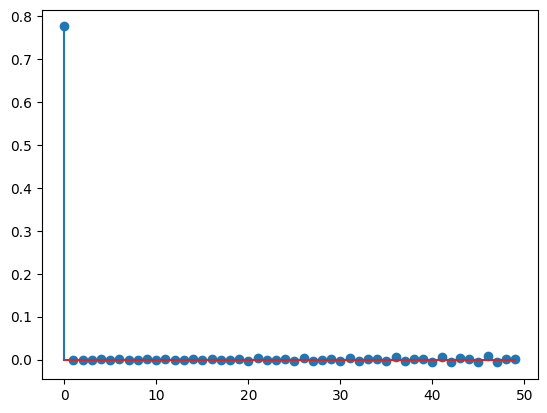

In [112]:
def calculate_ree_at_l(rxx, a, l):
    N = a.shape[0] - 1

    # rxx goes from 0 until rxx[49]
    rxx_length = rxx.shape[0] # 50

    val = 0.0

    l = abs(l)
    if (l < rxx_length): val += rxx[l]

    # goes from 1 to N
    for i in range(1, N+1):
        idx = l - i
        idx = abs(idx)
        if (idx < rxx_length): val -= a[i] * rxx[idx]

    for i in range(1, N+1):

        val_inside = 0.0

        for j in range(1, N+1):
            idx = l + i - j
            idx = abs(idx)
            if (idx < rxx_length): val_inside -= a[j] * rxx[idx]

        idx = abs(l + i)
        if (idx < rxx_length): val_inside += rxx[idx]

        val -= a[i] * val_inside

    return val

def calculate_ree_at_l_2(rxx, h, l):
    N = h.shape[0] -1 # se vai até h[30], N = 30
    rxx_length = rxx.shape[0] # 50
    
    val = 0.0
    for i in range(N+1):
        for j in range(N+1):
            idx = abs(i - j + l)
            if (idx < rxx_length):
                val += h[i] * h[j] * rxx[idx]
    
    return val


def calculate_acf_pred_error(rxx, a):
    hpef = np.zeros_like(a)
    hpef = hpef - a
    hpef[0] = 1

    # plt.stem(a)
    # plt.show()
    # plt.stem(hpef)
    # plt.show()

    ree = [calculate_ree_at_l(rxx, a, l) for l in range(len(rxx))]
    print(ree)

    plt.stem(ree)

calculate_acf_pred_error(rxx, a49)

    


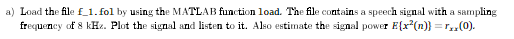

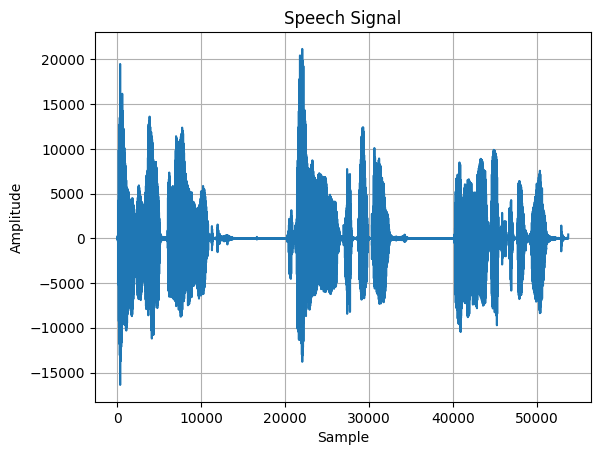

In [113]:
x = np.loadtxt("f_1.fol")

fs = 8000

plt.plot(x)
plt.title("Speech Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [114]:
print(np.sum(np.square(x)))

330749644788.0


In [115]:
autocorr = np.correlate(x, x, mode='full') / len(x)

(53719,)
(107437,)
6157032.796366276


<StemContainer object of 3 artists>

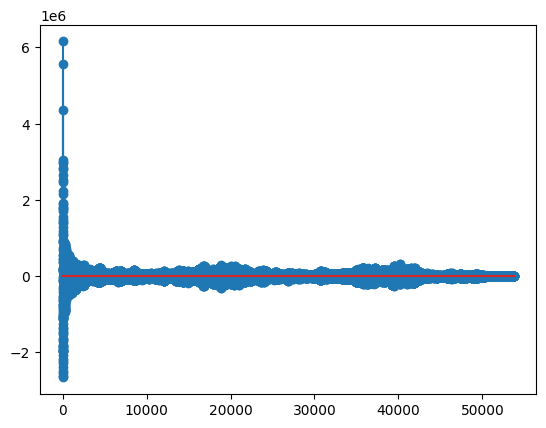

In [116]:
print(x.shape)
print(autocorr.shape)

print(autocorr[len(x) - 1])

plt.stem(autocorr[len(x) -1:])

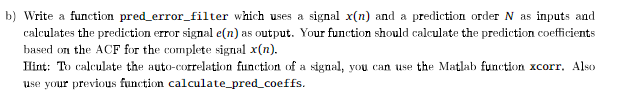

In [117]:
def pred_error_filter(x, N):
    rxx = np.correlate(x, x, mode='full') /len(x)
    rxx = rxx[len(x)-1:]
    a, Emin = calculate_pred_coeffs(rxx, N)

    h = np.zeros_like(a)
    h[0] = 1
    h = h-a

    e = np.convolve(h, x, mode='full')[:len(x)]

    # plt.subplot(211)
    # plt.plot(e[21000:25000])
    # plt.subplot(212)
    # plt.plot(x[21000:25000])

    return e

pred_error_filter(x, 20)


array([  66.        , -114.94424984,   94.05554032, ...,   11.21072205,
        330.17025616,  -93.46997513])

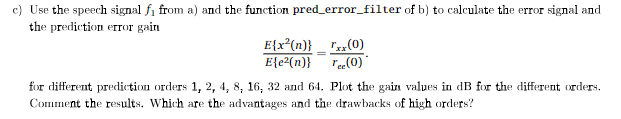

In [121]:
def prediction_error_gain(x, N):
    e = pred_error_filter(x, N)
    return np.mean(np.square(x))/np.mean(np.square(e))


N_values = [1, 2, 4, 8, 16, 32, 64]

pegs = np.zeros_like(N_values)

pegs = [prediction_error_gain(x, N) for N in N_values]
print(pegs)


[5.477689066380732, 8.678838418325443, 8.864994971783599, 9.131008623960085, 9.654452902800541, 11.243539334127846, 12.636685853556811]


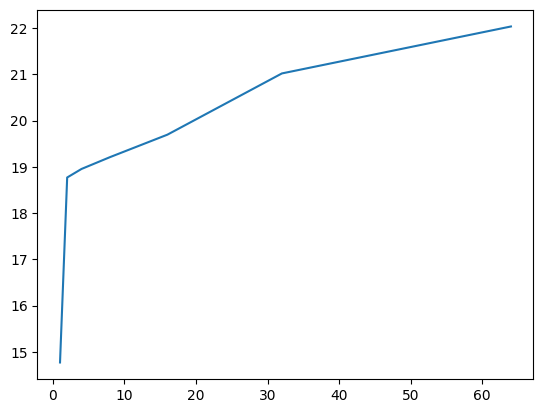

In [119]:

plt.plot(N_values, 20*np.log10(pegs))